In [1]:
# Given a +- score what is the probability of winning the game?

In [1]:
!scp -r boltio.schrodinger.com:/nfs/working/deep_learn/leswing/madness/models/20 ./

reg_model.pt                                  100%  298KB 979.5KB/s   00:00    
model_checkpoint.pt                           100%  891KB   1.6MB/s   00:00    
reg_model.pt                                  100%  298KB   1.9MB/s   00:00    
model_checkpoint.pt                           100%  891KB   2.9MB/s   00:00    
reg_model.pt                                  100%  298KB   3.5MB/s   00:00    
model_checkpoint.pt                           100%  891KB   4.4MB/s   00:00    
reg_model.pt                                  100%  298KB   5.1MB/s   00:00    
model_checkpoint.pt                           100%  891KB   5.9MB/s   00:00    
reg_model.pt                                  100%  298KB   5.9MB/s   00:00    
model_checkpoint.pt                           100%  891KB   5.1MB/s   00:00    
reg_model.pt                                  100%  298KB   5.3MB/s   00:00    
model_checkpoint.pt                           100%  891KB   6.2MB/s   00:00    
reg_model.pt                            

In [2]:
!mv 20 models

In [3]:
import hashlib
import os
import numpy as np
import pickle
import json

from ligand_ml.data import NumpyDataset
from ligand_ml.data import DiskDataset
from ligand_ml.models.torchm.model_mechanics import DenseModel


def load_transformers():
    with open('transformers.pkl', 'rb') as fin:
        return pickle.load(fin)


def get_team_fvs(year):
    d = json.loads(open('team_fvs.json').read())

    X = []
    team_names = []
    for k, v in d.items():
        if k.find(year) == -1:
            continue
        X.append(v[0])
        team_names.append(k)

    print(len(team_names))
    ds = NumpyDataset(X, np.ones(len(X)), np.ones(len(X)), range(len(X)))

    return ds.X, team_names


def create_dataset(year):
    fvs, team_names = get_team_fvs(year)
    X = []
    for i, t1 in enumerate(team_names):
        for j, t2 in enumerate(team_names):
            if j <= i:
                continue
            fv1 = np.concatenate([fvs[i], fvs[j]])
            fv2 = np.concatenate([fvs[j], fvs[i]])
            X.append(fv1)
            X.append(fv2)
    print(np.array(X).shape)
    ds = NumpyDataset(X, np.ones(len(X)), np.ones(len(X)), range(len(X)))
    transformers = load_transformers()
    for trans in transformers:
        ds = trans.transform(ds)
    return ds


def make_predictions(ds, model_key):
    transformers = load_transformers()
    all_preds = []
    for fold in range(5):
        path = os.path.join('models', model_key, str(fold))
        d = DenseModel(path, mode='regression')
        preds = np.squeeze(d.predict(ds))
        preds = transformers[1].untransform(preds)
        all_preds.append(preds)

    retval = np.mean(all_preds, axis=0)
    print(f"Predictions shape {retval.shape}")
    return retval


def convert_to_games(predictions, year):
    fvs, team_names = get_team_fvs(year)
    games = []
    for i, t1 in enumerate(team_names):
        for j, t2 in enumerate(team_names):
            if j <= i:
                continue
            games.append((t1, t2))

    results = {}
    index = 0
    while index < len(predictions):
        v1, v2 = predictions[index], predictions[index + 1]
        v2 *= -1
        average = (v1 + v2) / 2

        t1, t2 = games[index // 2]
        results[f"{t1}:{t2}"] = average
        results[f"{t2}:{t1}"] = average * -1
        index += 2
    return results


def play_year(year):
    with open('models/best_params.json', 'r') as fin:
        best_params = json.loads(fin.read())
    model_key = hashlib.md5(str(best_params).encode('utf-8')).hexdigest()

    ds = create_dataset(year)
    predictions = make_predictions(ds, model_key)
    predictions = convert_to_games(predictions, year)
    with open(f'results_{year}.json', 'w') as fout:
        fout.write(json.dumps(predictions, indent=4, sort_keys=True))


/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leswing/miniconda3/envs/ligand_ml/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [4]:
with open('models/best_params.json', 'r') as fin:
    best_params = json.loads(fin.read())
model_key = hashlib.md5(str(best_params).encode('utf-8')).hexdigest()


In [5]:
import pandas as pd

def get_fold_df(fold):
    transformers = load_transformers()
    ds = DiskDataset(f'datasets/full_folds/valid{fold}')
    preds = make_predictions(ds, model_key)
    
    num_games = ds.X.shape[0]//2
    first_games = ds.X[:num_games,:]
    second_games = ds.X[num_games:,:]
    
    avg_results = []
    for i in range(num_games):
        v = (preds[i] + preds[i+num_games]*-1) / 2
        avg_results.append(v)
    other_way_games = np.array(avg_results) * -1
    y_avg = np.concatenate([avg_results, other_way_games])
    true_points = np.squeeze(transformers[1].untransform(ds.y))
    df = pd.DataFrame(list(zip(true_points, y_avg)), columns=["y_true", "y_pred"])
    return df
    
def get_all_games():
    dfs = []
    for i in range(5):
        df = get_fold_df(i)
        dfs.append(df)
    return pd.concat(dfs)

In [6]:
all_game_df = get_all_games()

Predictions shape (14358,)
Predictions shape (14358,)
Predictions shape (14358,)
Predictions shape (14358,)
Predictions shape (14358,)


In [57]:
from copy import deepcopy
def get_probability_map(df):
    bounds = [-float('inf'), -20, -15, -10, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 10, 15, 20, float('inf')]
    probs = [0]
    for i in range(1, len(bounds)):
        my_df = deepcopy(df)
        my_df['is_more'] = my_df['y_pred'] > bounds[i-1]
        my_df['is_less'] = my_df['y_pred'] < bounds[i]
        my_df = my_df[my_df['is_more']]
        my_df = my_df[my_df['is_less']]


        my_df['has_won'] = my_df['y_true'] > 0

        #is_wrong = len(my_df) - sum(my_df['is_correct'])
        if len(my_df) == 0:
            print(f"No Values for {bounds[i]}")
            probs.append(0)
        else:
            probs.append(sum(my_df['has_won']) / len(my_df))
    return bounds, probs

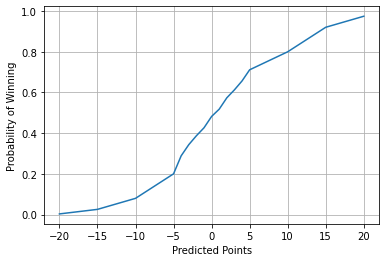

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
bounds, probs = get_probability_map(all_game_df)
plt.grid()
plt.ylabel("Probability of Winning")
plt.xlabel("Predicted Points")
plt.plot(bounds, probs)

In [11]:
d = {
    "probs": probs,
    "bounds": bounds
}
with open('model_results/probs_and_bounds.json', 'w') as fout:
    fout.write(json.dumps(d, indent=4, sort_keys=True))